# Day Clustering

In [9]:
import polars as pl
import re
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import logging
from datetime import date, datetime
from datetime import timedelta

from tslearn.clustering import TimeSeriesKMeans 
logging.getLogger('matplotlib.font_manager').disabled = True
from validation import validation

In [10]:
pattern = f"{r'DATA/SM_DATA_average_min'}/*CH*.csv"
file_paths = glob.glob(pattern)

## Loading files containing the day energy consumption patterns of the households

In [11]:
n_timestamps = 96

data_list = []

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)

data_3d = np.concatenate(data_list, axis=0)
print(f"Shape of the 3D array: {data_3d.shape}")

train_data = data_3d

Shape of the 3D array: (1464, 96, 1)


# Validation Metric
Default runs Davies-Bouldin, Silhoutte score and Calinski Harabasz scores can be plotted by uncommenting few lines

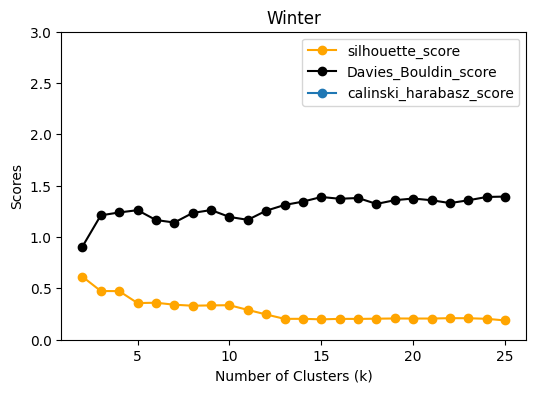

In [12]:
validation(train_data)

# K-means Clustering
change n_clusters as required

In [13]:


n_clusters = 7  # Number of clusters, you can adjust this
max_iterations =100

kmeans = TimeSeriesKMeans(n_clusters=n_clusters,max_iter=max_iterations, verbose=True, random_state=42, n_jobs=-1)
clusters_train = kmeans.fit_predict(train_data)

0.300 --> 0.185 --> 0.179 --> 0.176 --> 0.175 --> 0.174 --> 0.174 --> 0.173 --> 0.173 --> 0.172 --> 0.171 --> 0.171 --> 0.170 --> 0.170 --> 0.170 --> 0.170 --> 0.170 --> 


Saving the cluster indices

In [14]:
#Saving the cluster_indices

# Initialize an empty list to store individual DataFrames for each cluster
cluster_dataframes = []

for cluster_idx in range(n_clusters):
    # Get all indices in this cluster
    cluster_indices = np.where(clusters_train == cluster_idx)[0]
    
    # Create a Polars DataFrame for the current cluster's indices
    cluster_df = pl.DataFrame({
        "cluster": pl.Series([cluster_idx + 1] * len(cluster_indices)),
        "index": pl.Series(cluster_indices)
    })
    
    # Append this cluster DataFrame to the list
    cluster_dataframes.append(cluster_df)

# Concatenate all cluster DataFrames into one
cluster_indices_df = pl.concat(cluster_dataframes)

# Print the DataFrame to verify
print("\nCluster Indices DataFrame:")
print(cluster_indices_df.head())

#cluster_indices_df.write_csv(rf'C:\DATA\{season}_avg_{n_clusters}_indices.csv')


Cluster Indices DataFrame:
shape: (5, 2)
┌─────────┬───────┐
│ cluster ┆ index │
│ ---     ┆ ---   │
│ i64     ┆ i64   │
╞═════════╪═══════╡
│ 1       ┆ 1     │
│ 1       ┆ 2     │
│ 1       ┆ 4     │
│ 1       ┆ 5     │
│ 1       ┆ 6     │
└─────────┴───────┘


# Plotting the cluster average patterns

In [15]:
labels = ['0:00','6:00','12:00','18:00','0:00']

colors= ['black','blue','red','maroon','lightgrey','pink','darkgrey','darkblue','skyblue','indianred','purple','magenta','pink','violet']

def plot_clusters_season(save):
    
    plt.figure(figsize=(8,6))
    for cluster_idx in range(n_clusters):
        # Get all time series in this cluster
        cluster_data = train_data[clusters_train == cluster_idx]
        cluster_indices = np.where(clusters_train == cluster_idx)[0]    
    
        # Calculate the mean time series for the cluster
        mean_time_series = np.mean(cluster_data, axis=0)
    
        # Plot the mean time series
        cluster_no = cluster_idx+1
        plt.plot(range(1,97), mean_time_series.ravel(), 
                label= f'{cluster_no} Number of Time Series: {len(cluster_indices)}',
                linewidth =2, color=colors[cluster_idx] )
    plt.title("daily_profiles")
    plt.xlabel("Time")
    plt.ylabel(" Normalized Energy Consumption")
    plt.ylim(0,1)
    #plt.xticks(range(1,108,12),labels=labels)
    plt.xticks(range(1,120,24),labels=labels)
    plt.tight_layout()
    #plt.legend()
    #plt.margins(0)
    plt.grid(True, color = 'lightgray')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

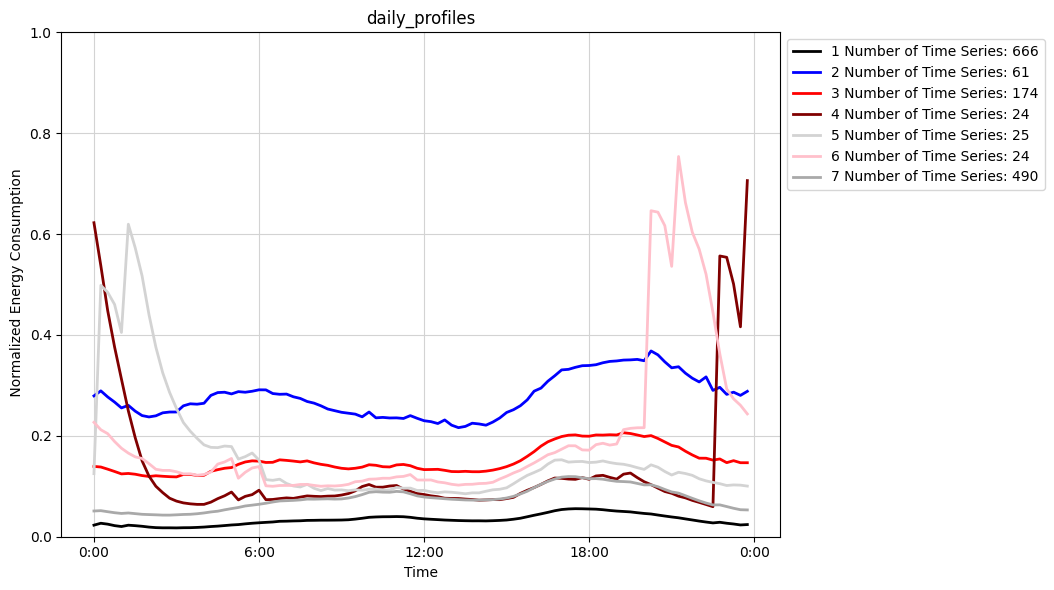

In [16]:
to_save = 0 #if you want to save the plots save=1

plot_clusters_season(to_save)

plt.rcParams['font.size'] = 14

### Plotting the clusters in separate plots

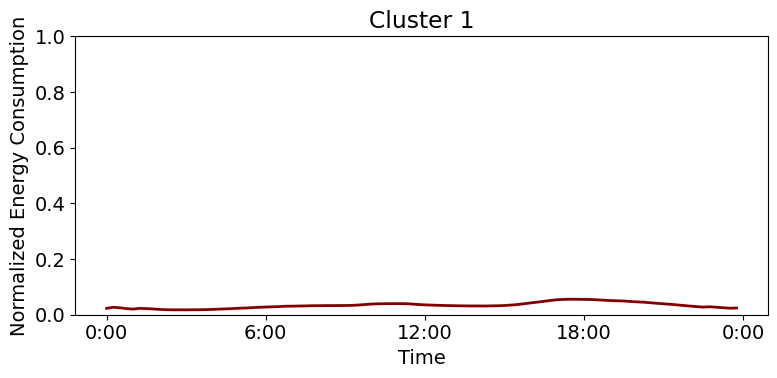

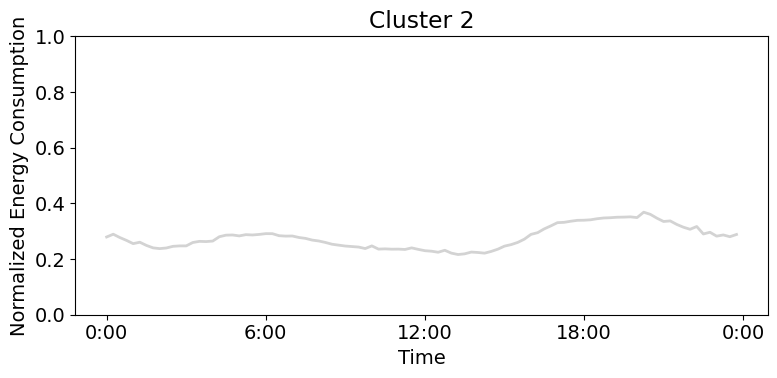

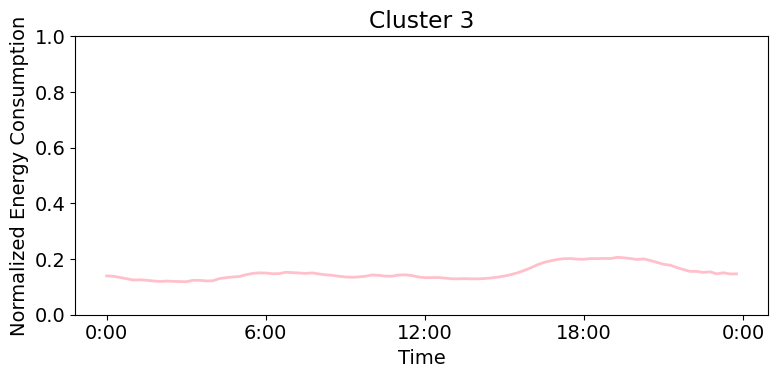

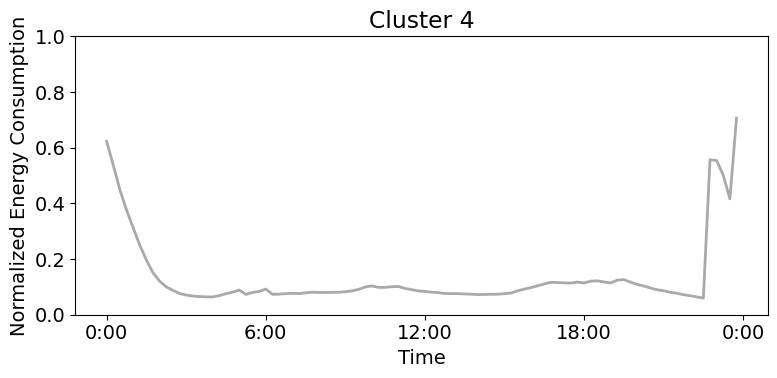

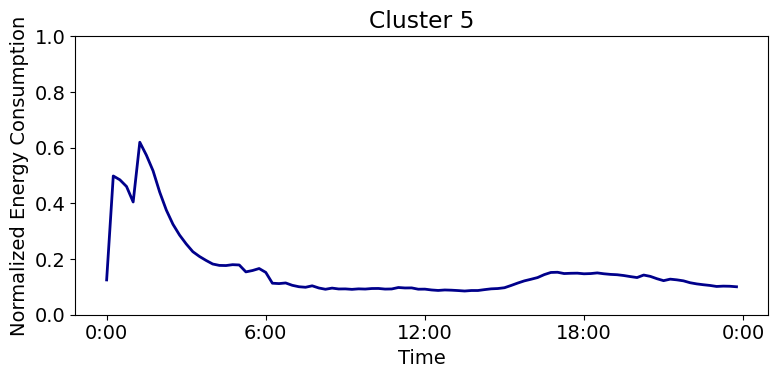

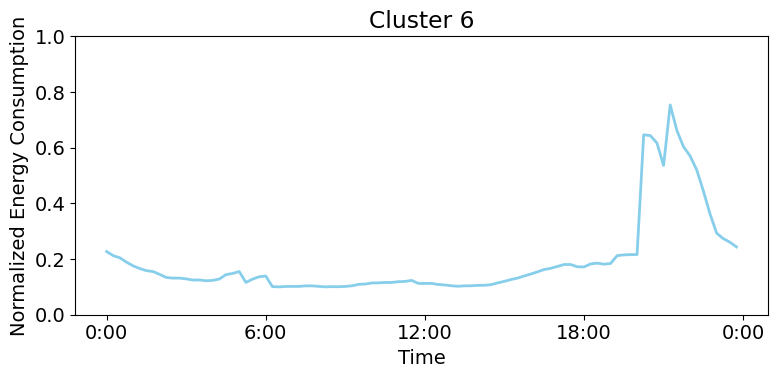

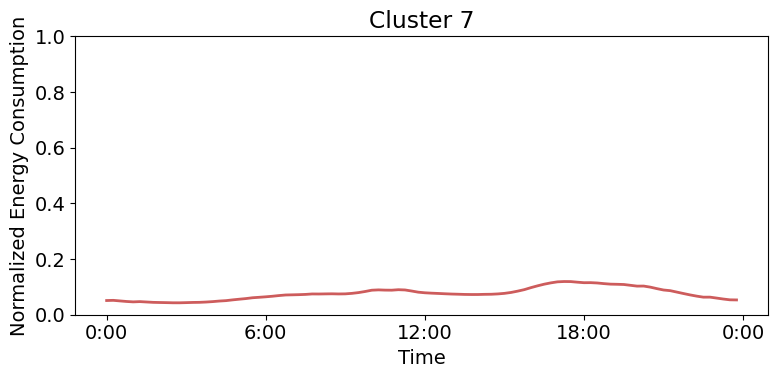

In [ ]:
# Calculate and plot the average pattern for each cluster
save = 0 #if you want to save the plots

labels = ['0:00','6:00','12:00','18:00','0:00']
colors= ['maroon','lightgrey','pink','darkgrey','darkblue','skyblue','indianred','purple','darkslategrey','turquoise','magenta','pink','violet']

for cluster_idx in range(n_clusters):
    # Get all time series in this cluster
    cluster_data = train_data[clusters_train == cluster_idx]
    cluster_indices = np.where(clusters_train == cluster_idx)[0]    
    
    
    # Calculate the mean time series for the cluster
    mean_time_series = np.mean(cluster_data, axis=0)
    
    # Plot the mean time series
    plt.figure(figsize=(8, 4))
    
    plt.plot(range(1,97), mean_time_series.ravel()[:96], 
             label= f'Mean Time Series \n No. of Time Series: {len(cluster_indices)}',
               linewidth =2, color= colors[cluster_idx] )
    cluster_no = cluster_idx+1
    plt.title(f"Cluster {cluster_no}")
    plt.xlabel("Time")
    plt.ylabel("Normalized Energy Consumption")
    plt.ylim(0,1)
    plt.xticks(range(1,120,24),labels=labels)
    plt.tight_layout()
    #plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()


### Plotting Mean, Median and percentiles of the clusters

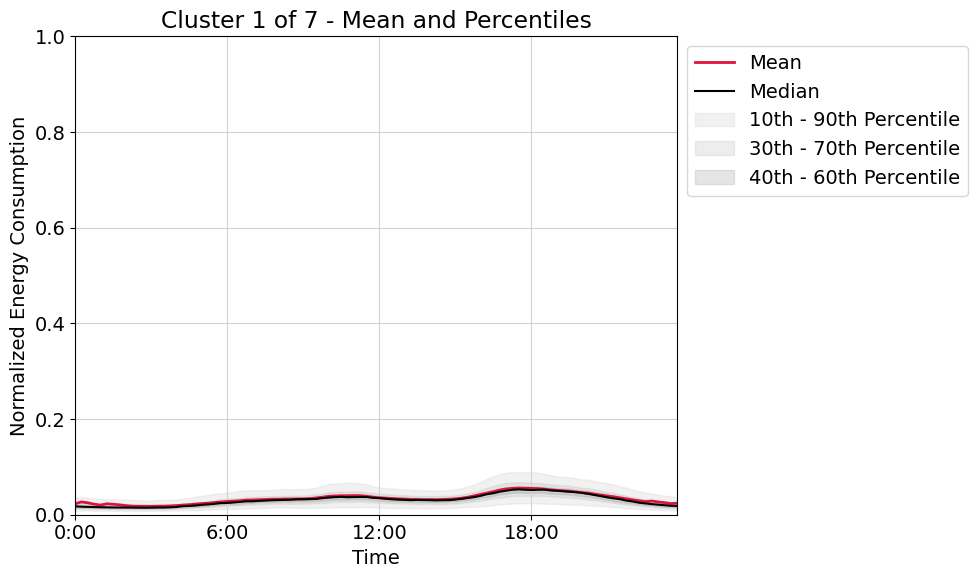

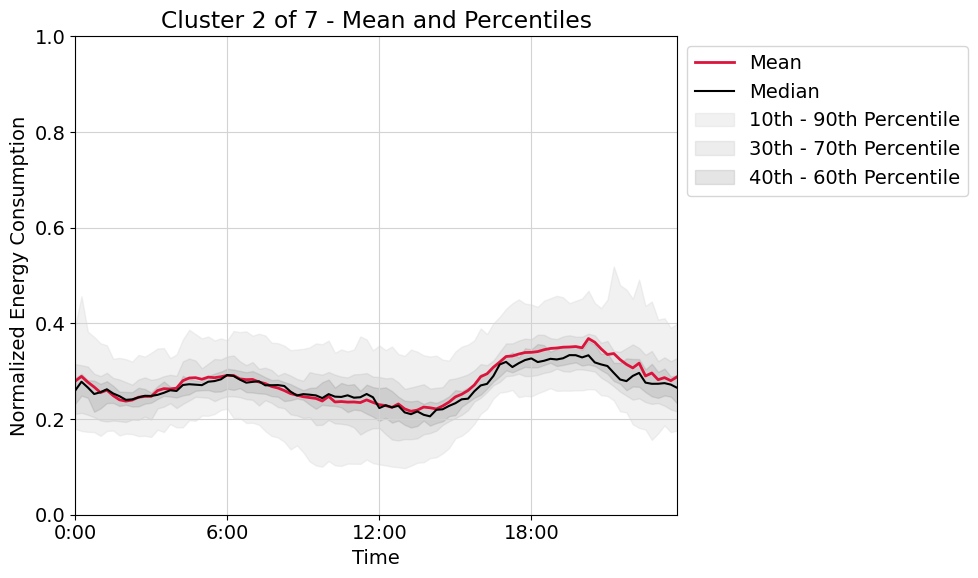

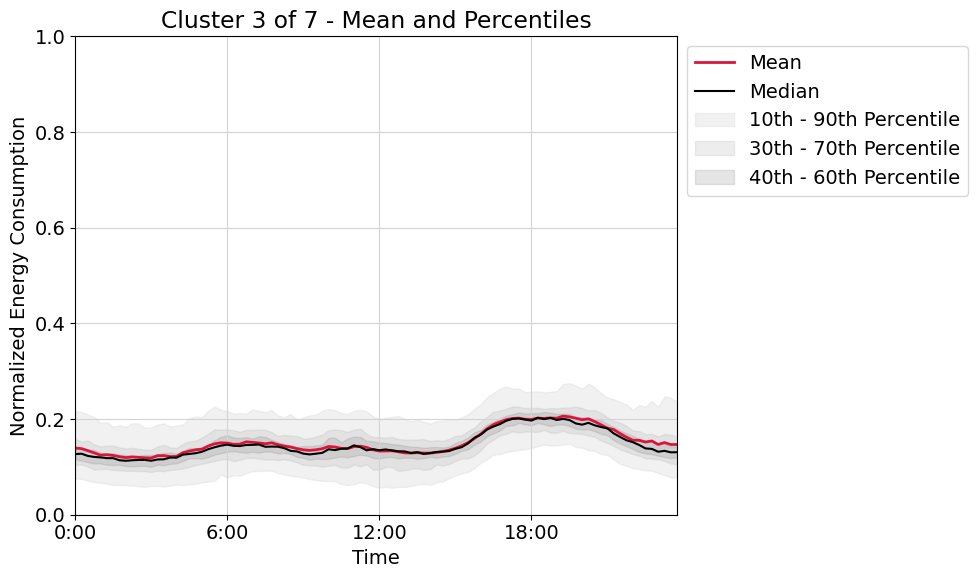

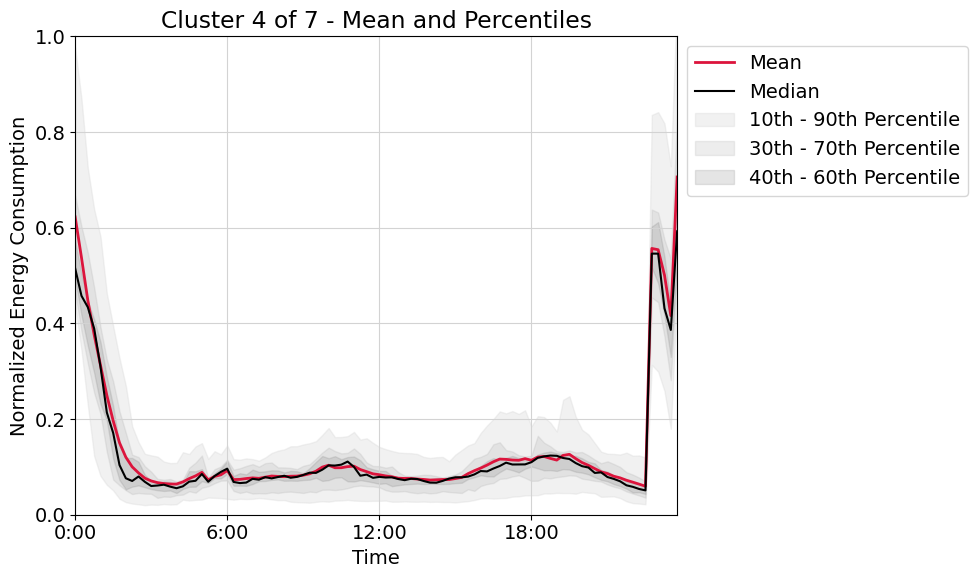

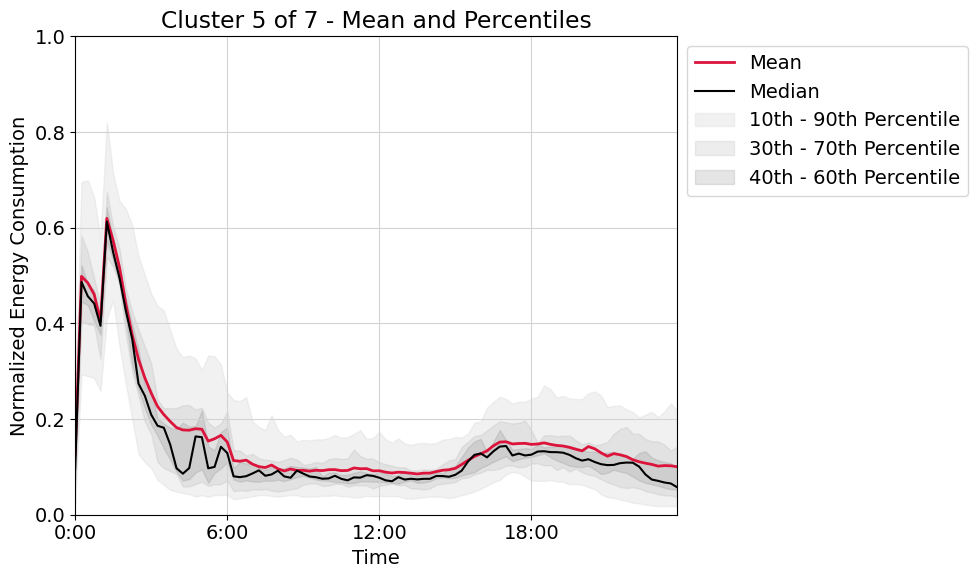

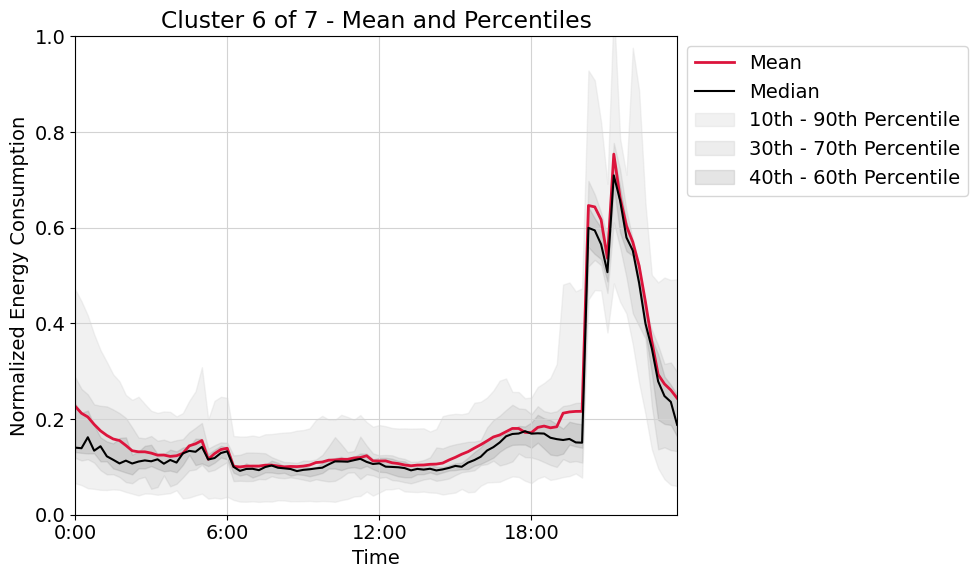

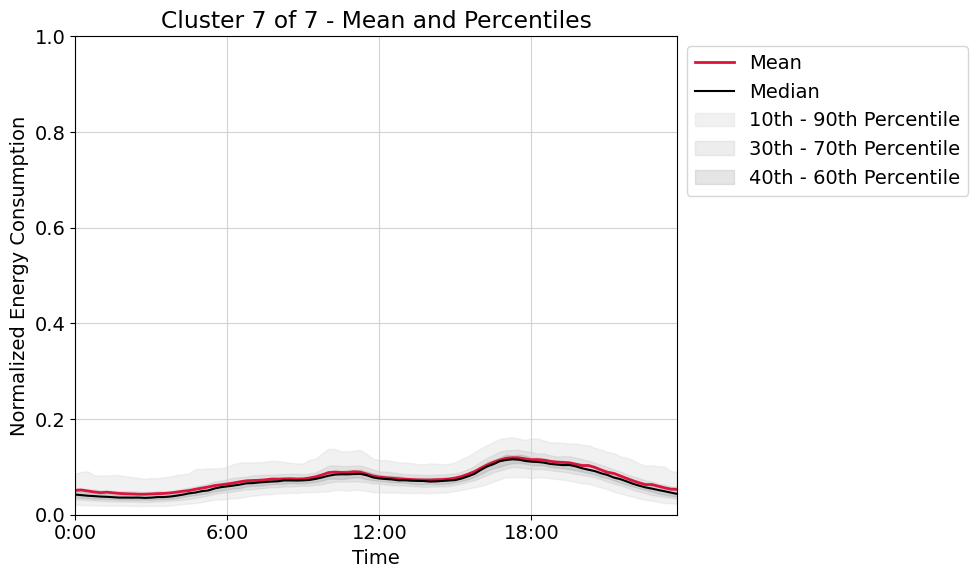

shape: (96, 14)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ lower_per ┆ lower_per ┆ lower_per ┆ lower_per ┆ … ┆ upper_per ┆ upper_per ┆ upper_per ┆ upper_pe │
│ centile_c ┆ centile_c ┆ centile_c ┆ centile_c ┆   ┆ centile_c ┆ centile_c ┆ centile_c ┆ rcentile │
│ luster_1  ┆ luster_2  ┆ luster_3  ┆ luster_4  ┆   ┆ luster_4  ┆ luster_5  ┆ luster_6  ┆ _cluster │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ _7       │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 0.0088    ┆ 0.179611  ┆ 0.075659  ┆ 0.438749  ┆ … ┆ 0.976576  ┆ 0.252417  ┆ 0.471102  ┆ 0.085904 │
│ 0.008596  ┆ 0.175081  ┆ 0.075101  ┆ 0.343559  ┆ … ┆ 0.868975  ┆ 0.695562 

In [34]:
plt.rcParams['font.size'] = 14

save = 0
save_file = 0
lower_percentile = 10
median_percentile = 50
upper_percentile = 90

# Percentiles to be used for shading
lower_shade_percentile = 30
mid_shade_percentile = 40
upper_shade_percentile = 70
top_shade_percentile = 60

# Initialize lists to store percentile data for each cluster
lower_percentile_columns = []
upper_percentile_columns = []

# Assuming train_weekdays and clusters_train are defined and n_clusters is set
for cluster_idx in range(n_clusters):
    # Get all time series in this cluster
    cluster_data = train_data[clusters_train == cluster_idx]
    
    # Calculate the mean and percentiles for the cluster
    mean_time_series = np.mean(cluster_data, axis=0)
    median_time_series = np.median(cluster_data, axis=0)
    lower_percentile_series = np.percentile(cluster_data, lower_percentile, axis=0)
    median_percentile_series = np.percentile(cluster_data, median_percentile, axis=0)
    
    lower_shade_series = np.percentile(cluster_data, lower_shade_percentile, axis=0)
    mid_shade_series = np.percentile(cluster_data, mid_shade_percentile, axis=0)
    top_shade_series = np.percentile(cluster_data, top_shade_percentile, axis=0)
    upper_shade_series = np.percentile(cluster_data, upper_shade_percentile, axis=0)
    
    upper_percentile_series = np.percentile(cluster_data, upper_percentile, axis=0)

    # Convert to flat arrays if needed
    lower_percentile_series = np.ravel(lower_percentile_series)
    upper_percentile_series = np.ravel(upper_percentile_series)
    lower_shade_series = np.ravel(lower_shade_series)
    mid_shade_series = np.ravel(mid_shade_series)
    top_shade_series = np.ravel(top_shade_series)
    upper_shade_series = np.ravel(upper_shade_series)

    # Store results in lists
    lower_percentile_columns.append(pl.Series(f'lower_percentile_cluster_{cluster_idx+1}', lower_percentile_series))
    upper_percentile_columns.append(pl.Series(f'upper_percentile_cluster_{cluster_idx+1}', upper_percentile_series))
    
    # Plot the mean and percentile bands
    plt.figure(figsize=(10, 6))
    plt.grid( color='lightgray')
    plt.plot(range(1, 97), mean_time_series, label='Mean', color='crimson', linewidth=2)
    plt.plot(range(1, 97), median_time_series, label='Median', color='black', linewidth=1.5)
    
    # Fill between percentiles for shading
    plt.fill_between(range(1, 97), lower_percentile_series, upper_percentile_series, color='lightgray', alpha=0.3, label=f'{lower_percentile}th - {upper_percentile}th Percentile')
    plt.fill_between(range(1, 97), lower_shade_series, upper_shade_series, color='darkgray', alpha=0.2, label=f'{lower_shade_percentile}th - {upper_shade_percentile}th Percentile')
    plt.fill_between(range(1, 97), mid_shade_series, top_shade_series, color='gray', alpha=0.2, label=f'{mid_shade_percentile}th - {top_shade_percentile}th Percentile')
    
    plt.title(f"Cluster {cluster_idx + 1} of {n_clusters} - Mean and Percentiles")
    plt.xlabel("Time", fontsize = 14)
    plt.ylabel("Normalized Energy Consumption")
    plt.ylim(0, 1)
    plt.yticks(fontsize = 14)
    plt.xticks(range(1, 120, 24), labels=['0:00', '6:00', '12:00', '18:00', '0:00'], fontsize = 14)
    plt.margins(0)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
plt.show()

# Combine results into a Polars DataFrame
cluster_percentiles_df = pl.DataFrame(lower_percentile_columns + upper_percentile_columns)
print(cluster_percentiles_df)